## Imports

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

## Mount GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/NewsStocksData
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/NewsStocksData
catboost_info  new.xlsx  yahoo_data.xlsx


## Load data & transformations

The dataset includes the following columns:

**Date**: The date on which the stock market data was recorded.

**Open**: The opening price of the asset on the given date.

**High**: The highest price of the asset on the given date.

**Low**: The lowest price of the asset on the given date.

**Close**: The closing price of the asset on the given date. Note that this price does not take into account any after-hours trading that may have occurred after the market officially closed.

**Adj Close**: The adjusted closing price of the asset on the given date. This price takes into account any dividends, stock splits, or other corporate actions that may have occurred, which can affect the stock price.

**Volume**: The total number of shares of the asset that were traded on the given date.

In [ ]:
df = pd.read_excel('yahoo_data.xlsx')

In [ ]:
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Apr 28, 2023",33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,"Apr 27, 2023",33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,"Apr 26, 2023",33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,"Apr 25, 2023",33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,"Apr 24, 2023",33805.04,33891.15,33726.09,33875.40,33875.40,252020000


In [ ]:
# delete close as we have adjusted close which is more accurate
df = df.drop('Close*', axis=1)

In [ ]:
# string to datetime and sort ascending
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

## EDA

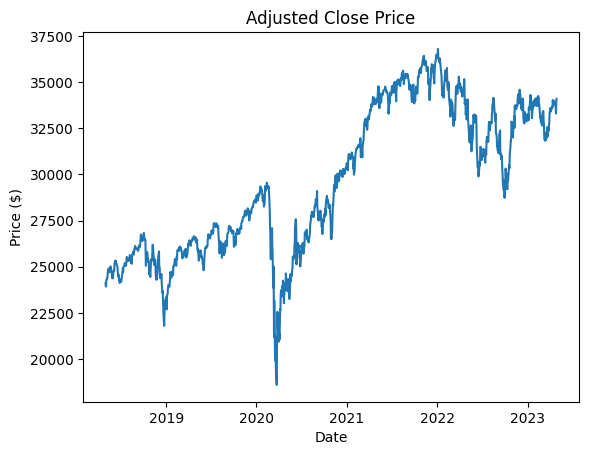

In [ ]:
plt.plot(df['Date'], df['Adj Close**'])
plt.title('Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

<ipython-input-64-24bed48b1dd1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


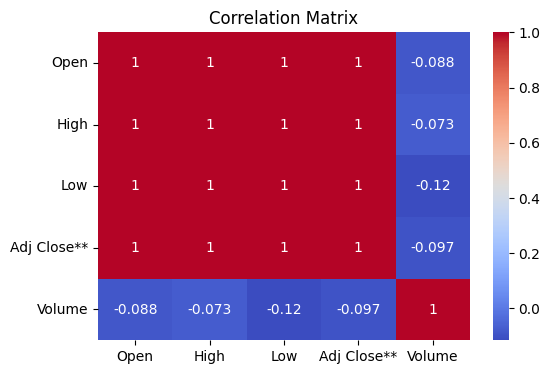

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show();

**Volume has very low correlation with other features!**

Checking NAN values:

In [ ]:
df.isna().sum()

Date           0
Open           0
High           0
Low            0
Adj Close**    0
Volume         0
dtype: int64

Volume traded

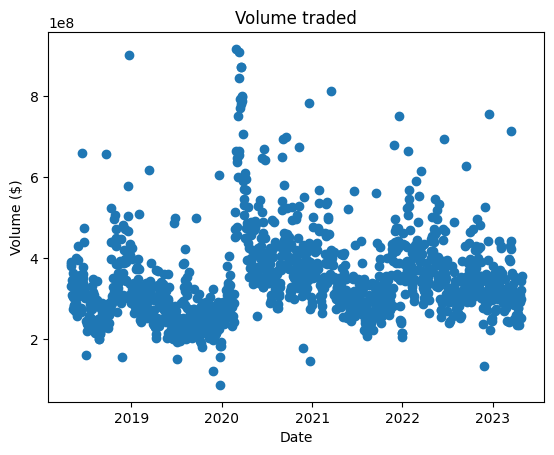

In [ ]:
plt.scatter(df['Date'], df['Volume'])
plt.title('Volume traded')
plt.xlabel('Date')
plt.ylabel('Volume ($)')
plt.show()

Resampling Adj Close column month wise

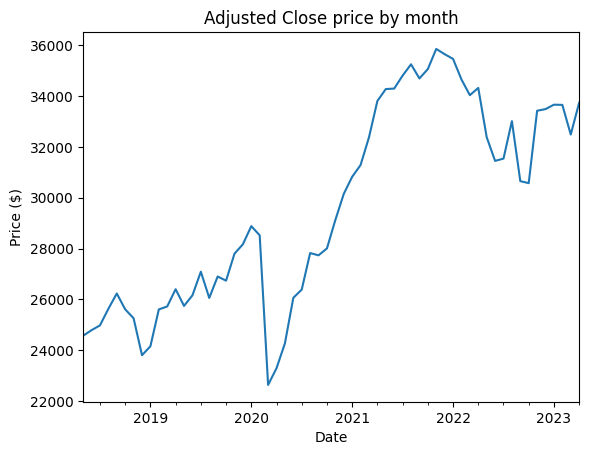

In [ ]:
df2 = df.set_index('Date')
df2['Adj Close**'].resample('M').mean().plot()
plt.title('Adjusted Close price by month')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

Resampling Adj Close column year wise

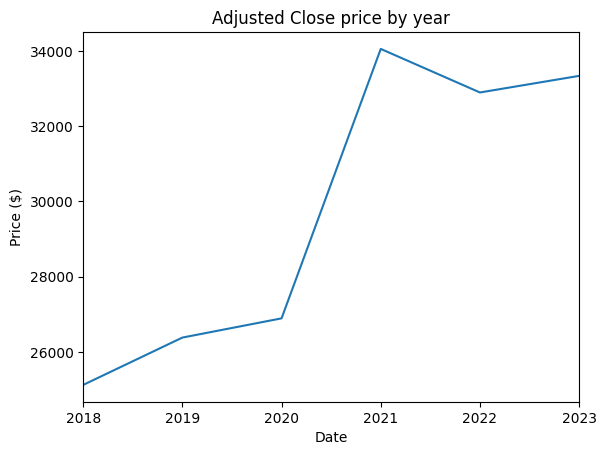

In [ ]:
df2['Adj Close**'].resample('Y').mean().plot()
plt.title('Adjusted Close price by year')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

## Dickey-Fuller Test for stationary

In [ ]:
def check_mean_std(ts):
    #Rolling statistics
    rolmean = ts.rolling(6).mean()
    rolstd = ts.rolling(6).std()
    plt.figure(figsize=(22,10))
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Closing Price")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

def check_adfuller(df):
  result=adfuller(df)
  print('Test Statistic: %f' %result[0])
  print('p-value: %f' %result[1])
  print('Critical values:')
  for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))


## Finding parameters for ARIMA algorithms

These parameters can be explained as follows

1.   p is the number of autoregressive terms,
2.   d is the number of nonseasonal differences,
3.   q is the number of lagged forecast errors in the prediction equation.



In [ ]:
data = df[['Adj Close**']]
data = data.set_index(df['Date'])
data.head(3)

,Adj Close**
Date,
2018-05-02,23924.98
2018-05-03,23930.15
2018-05-04,24262.51


<Axes: xlabel='Date'>

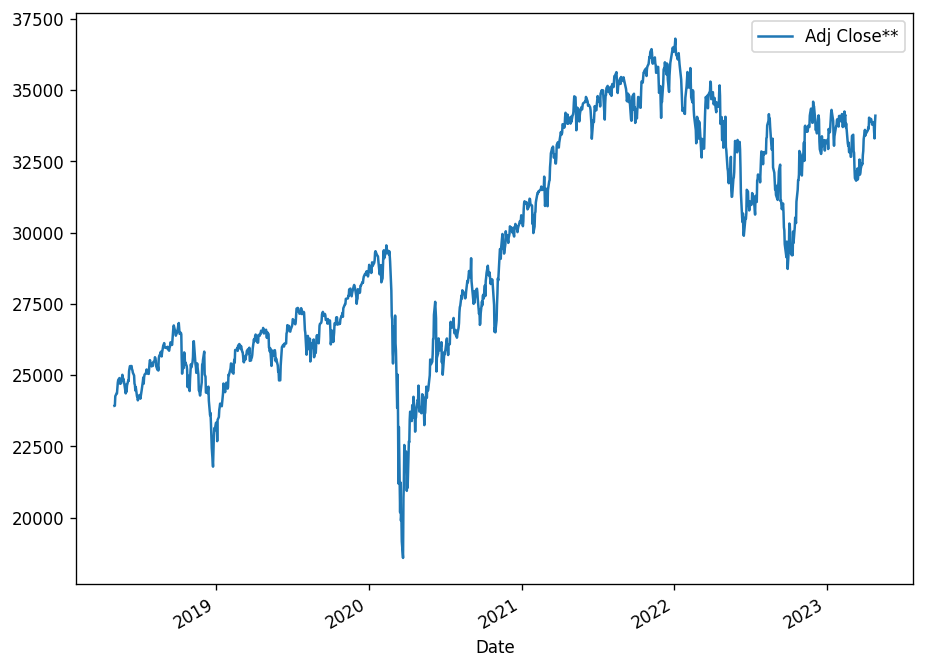

In [ ]:
data.plot()

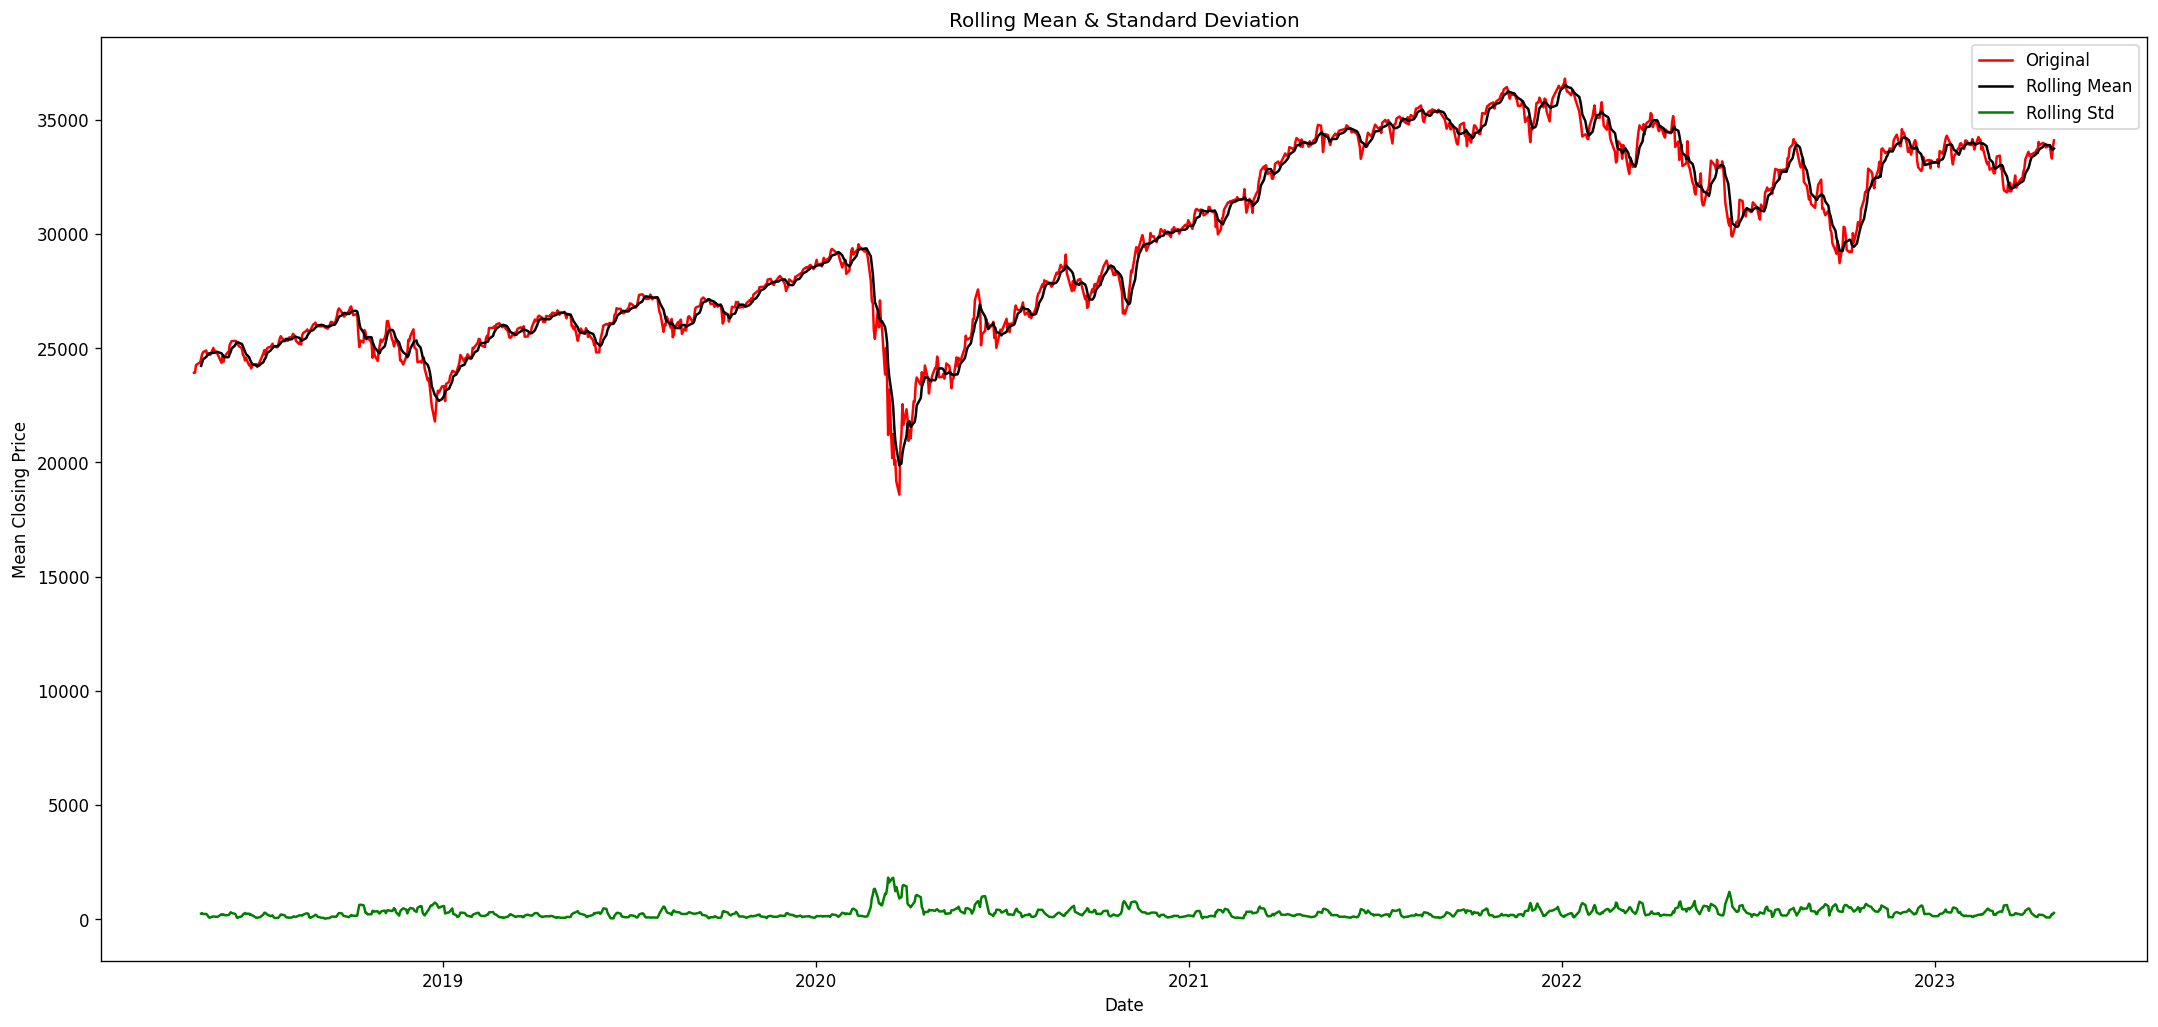

Test Statistic: -1.637118
p-value: 0.463767
Critical values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [ ]:
check_mean_std(data)
check_adfuller(data)

Our data is not stationary => we need to difference it!

In [ ]:
data = data.diff().dropna()

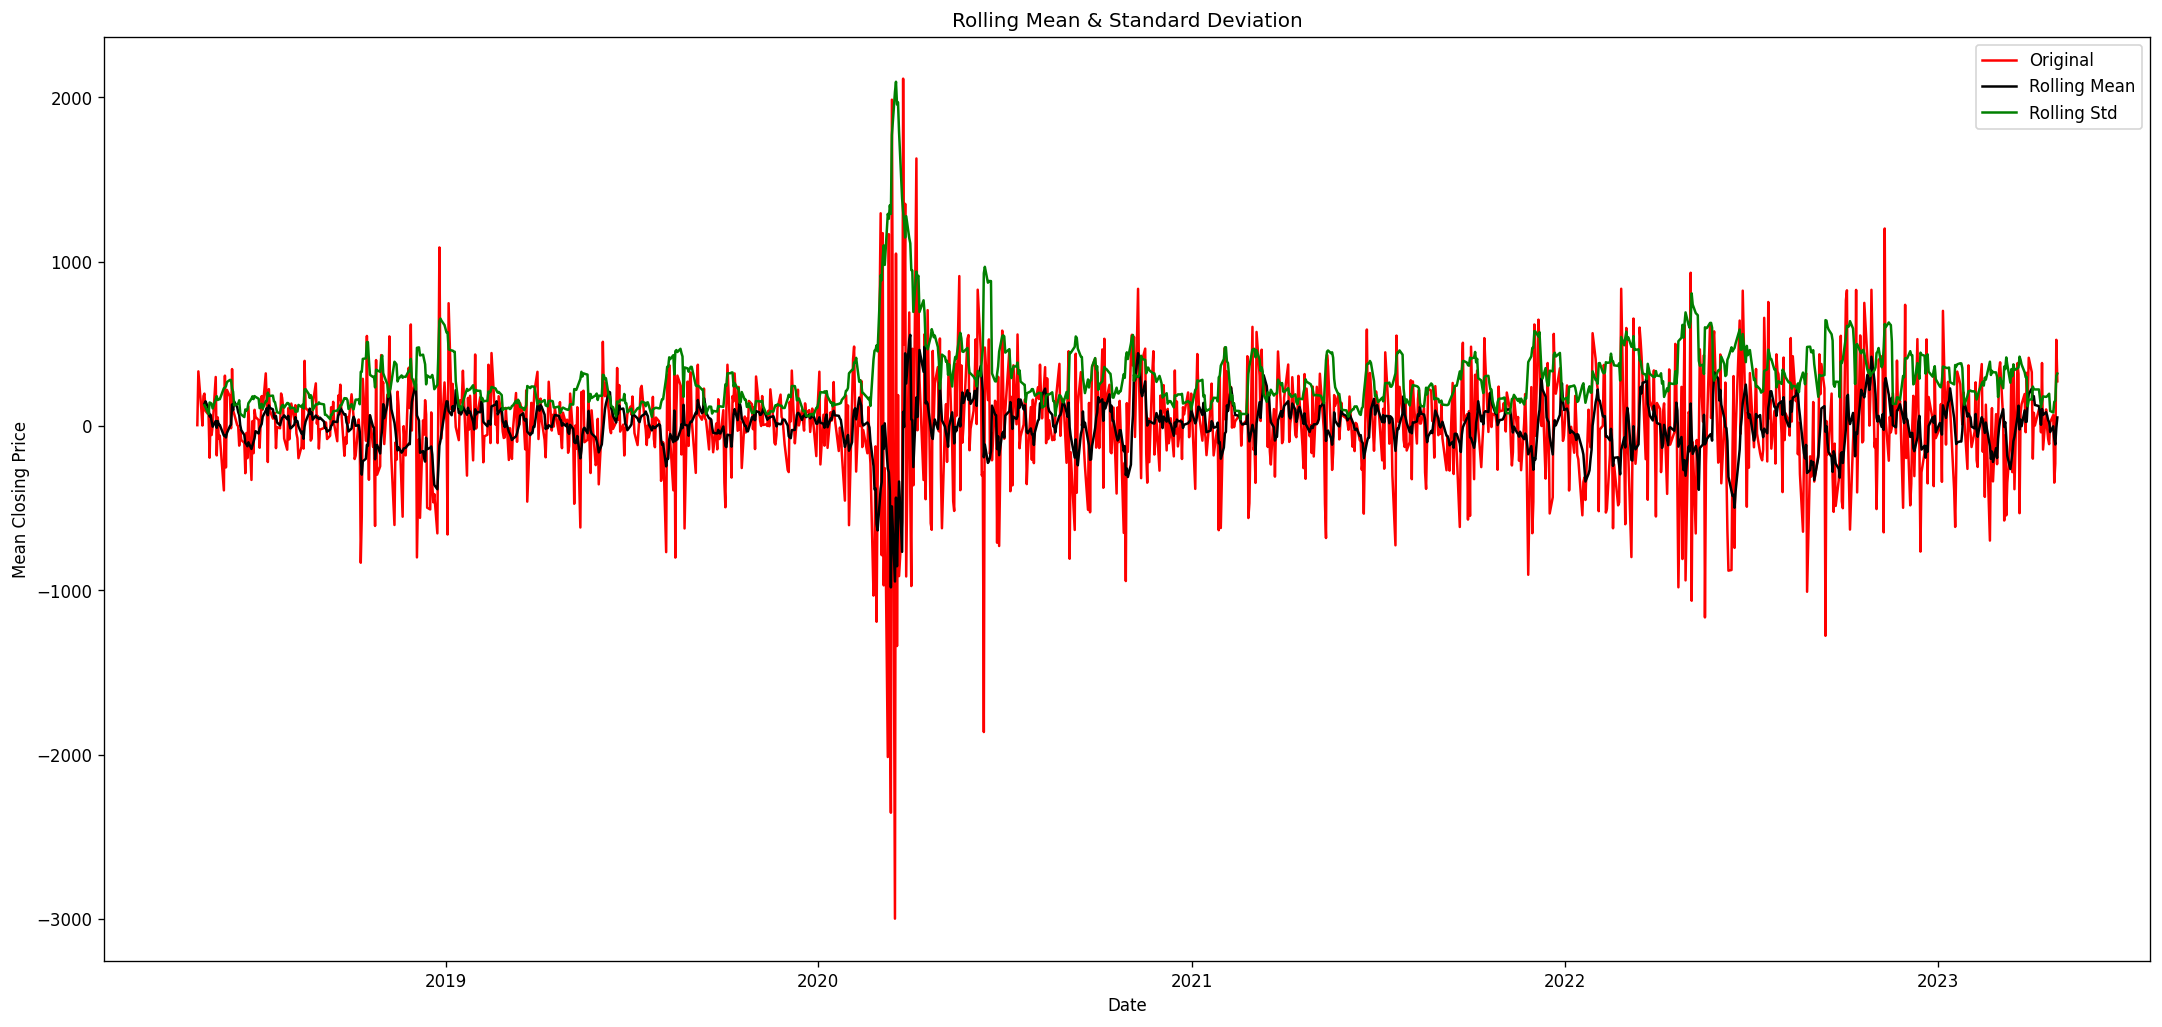

Test Statistic: -10.830945
p-value: 0.000000
Critical values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [ ]:
check_mean_std(data)
check_adfuller(data)

now it is stationary so we can continue

### Finding d parameter

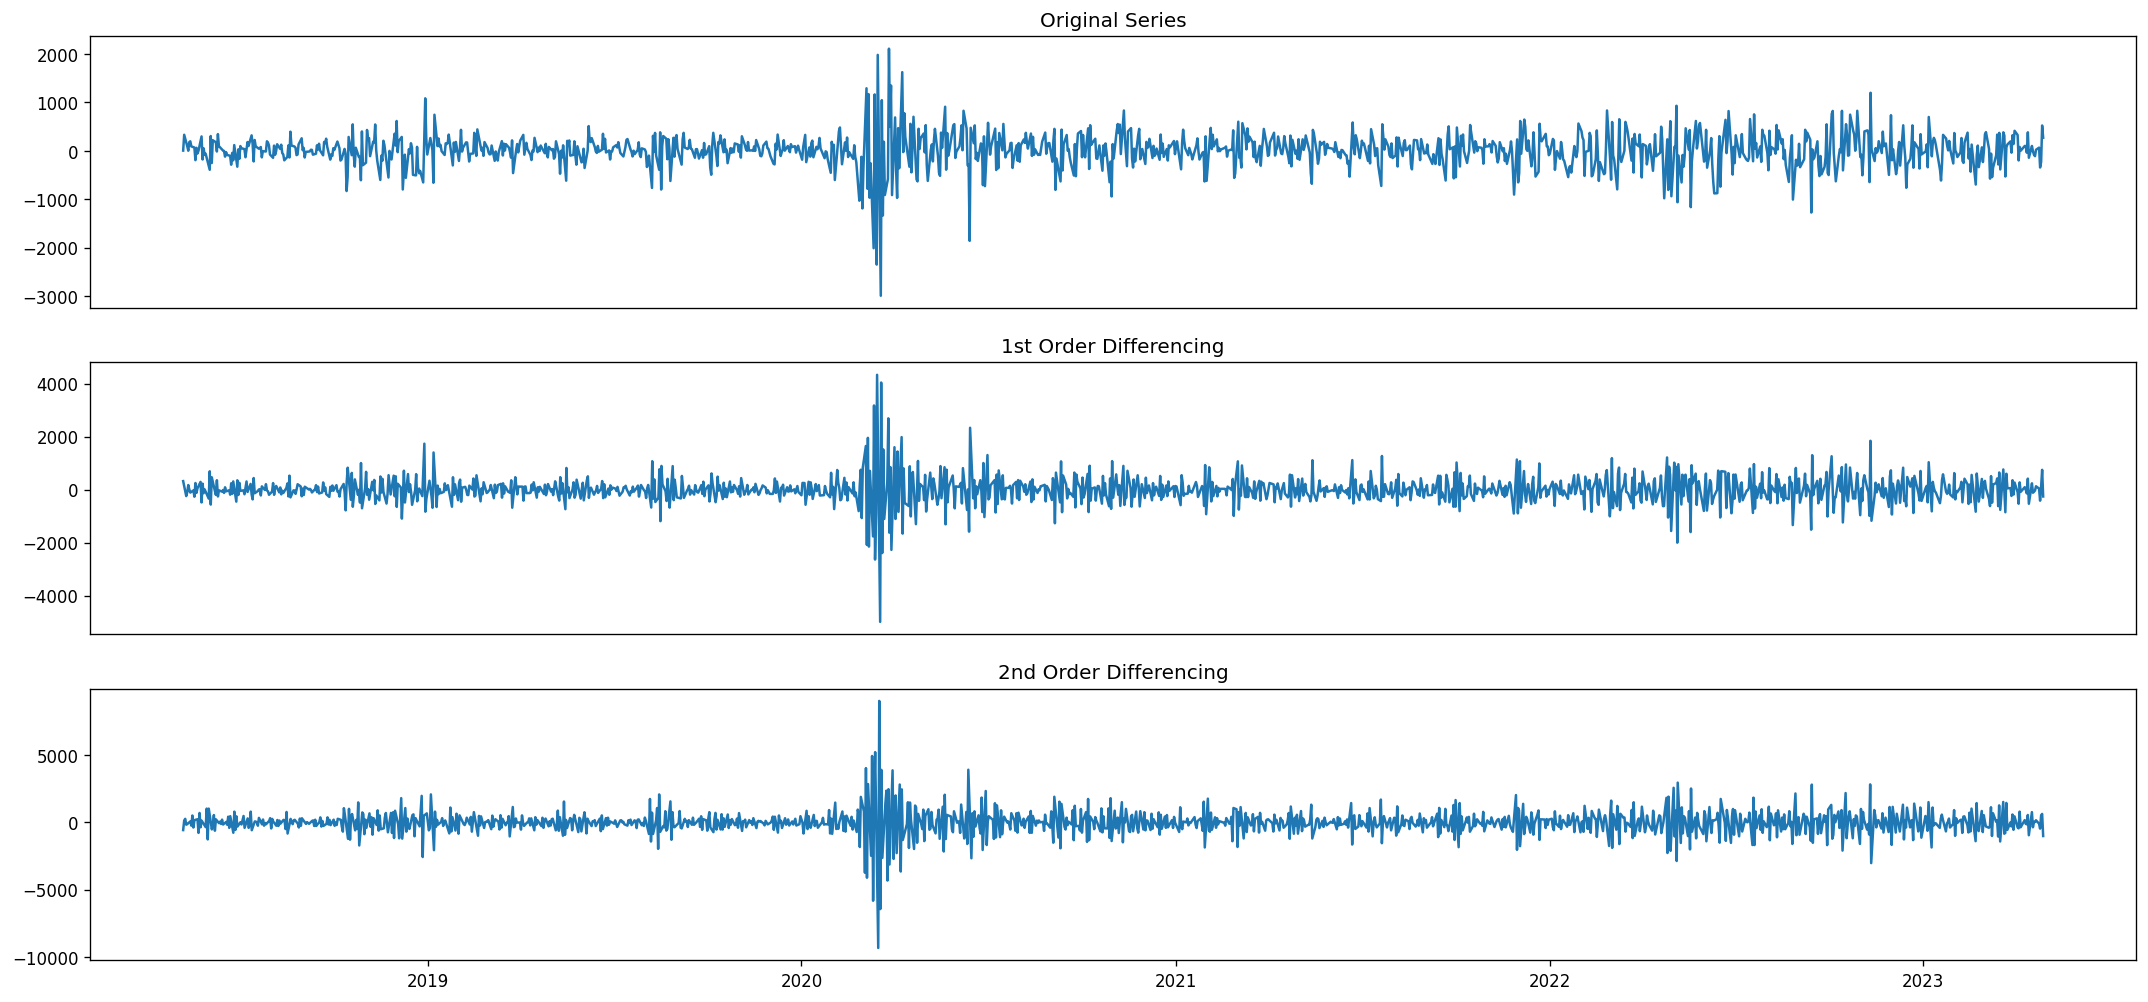

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(22,10)
ax1.plot(data);
ax1.set_title('Original Series');
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(data.diff());
ax2.set_title('1st Order Differencing');
ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(data.diff().diff());
ax3.set_title('2nd Order Differencing')
plt.show()

1 Differencing has less noise so we try it => d = 1

### Finding p parameter

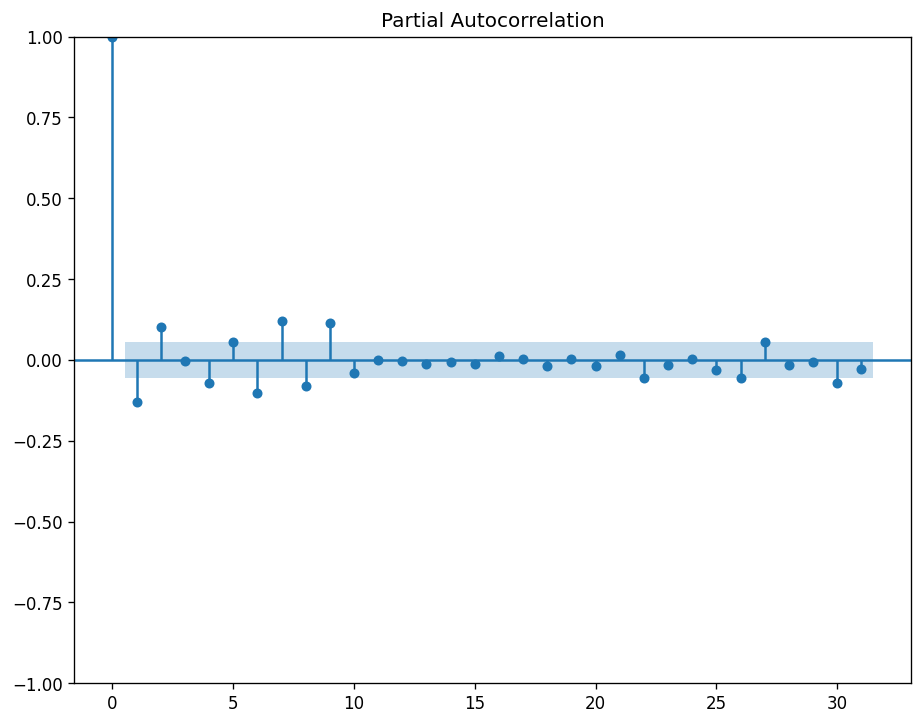

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data.diff().dropna())
plt.show()

We cannot conclude from this chart what p value is

### Finding q value

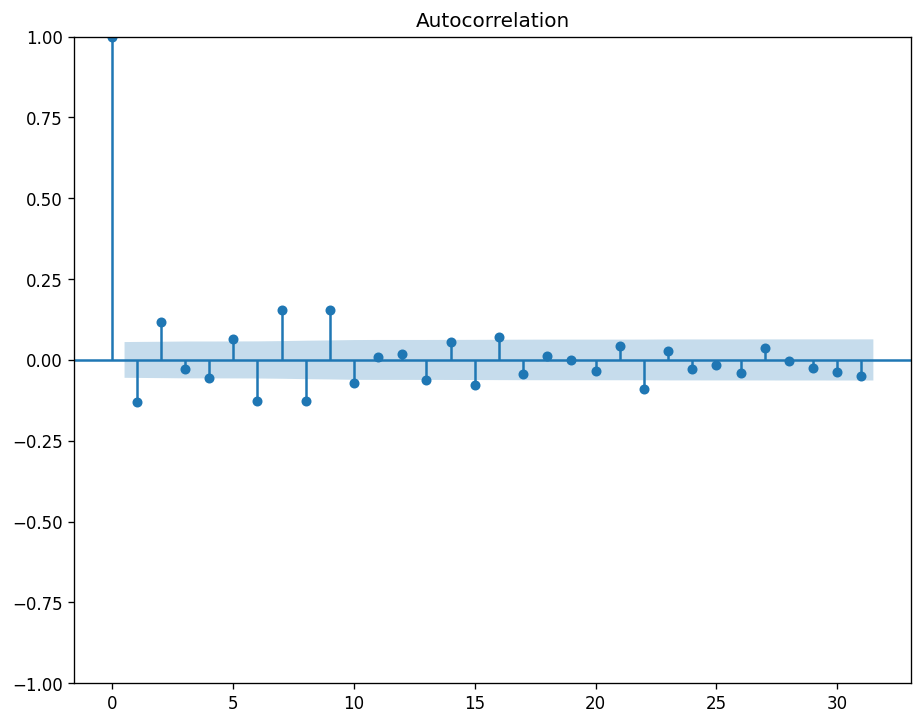

In [ ]:
plot_acf(data.diff().dropna())
plt.show()

The same is for q value. So we need to add exogenous variable (X)

## Catboost

In [ ]:
model = CatBoostRegressor(loss_function='RMSE', silent=True)

In [ ]:
df = df.drop('Adj Close Stationary', axis=1)

In [ ]:
X = df.drop('Adj Close**', axis=1)
y = df['Adj Close**']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
model = CatBoostRegressor(iterations=200,
                          learning_rate=0.1,
                          depth=4)
# Fit model
model.fit(X_train, y_train)
# Get predictions
preds = model.predict(X_test)

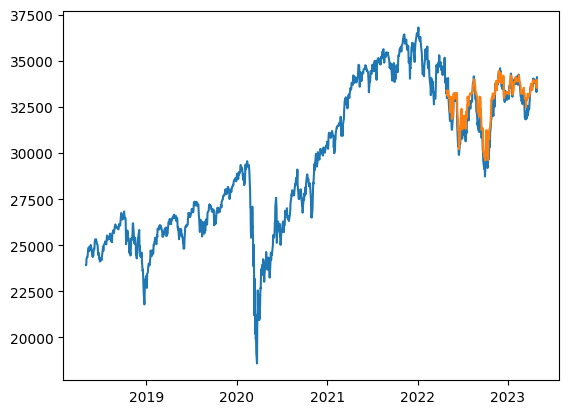

In [ ]:
# plt.plot(df['Date'], df['Open'])
plt.plot(df['Date'], df['Adj Close**'])
plt.plot(X_test['Date'], preds)
plt.show()

In [ ]:
model.best_score_

{'learn': {'RMSE': 163.7374985534965}}

## Catboost HP tuning

In [ ]:
# grid = {
#     'iterations': [100, 500, 1000],
#     'learning_rate': [0.01, 0.06, 0.1],
#     'depth':[3, 6, 9],
#     'l2_leaf_reg': [2, 3, 4],
#     'boosting_type': ['Ordered', 'Plain']
# }
# train_pool = Pool(X_train, y_train)
# grid_search_model = CatBoostRegressor(random_seed=42)
# grid_search_result = grid_search_model.grid_search(grid, train_pool, verbose=False)
# grid_search_result['params']

## CatBoost Cross Validation

In [ ]:
# scores = cv(cv_dataset,
#             params,
#             fold_count=2,
#             plot="True")